In [1]:
%load_ext autoreload
%autoreload 2

### Load the data

In [14]:
import pathlib
import os
import json
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import PIL
# TODO: add any imports you use here

from torch import nn

from utils.train_model import train_model, plot_stats

In [6]:
# Create a pytorch dataset
data_dir = pathlib.Path('./data/tiny-imagenet-200')
CLASS_NAMES = np.array([item.name for item in (data_dir / 'train').glob('*') if os.path.isdir(item.__str__())])

In [29]:
batch_size = 128
data_transforms = {x: transforms.Compose([
                          transforms.Resize((128, 128))])
                      for x in ['train', 'val']}
datasets = {x: torchvision.datasets.ImageFolder('./data/tiny-imagenet-200/val', data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True) for x in ['train', 'val']}

print("Training set size: ", len(datasets['train']))
print("Validation set size: ", len(datasets['val']))

Training set size:  10000
Validation set size:  10000


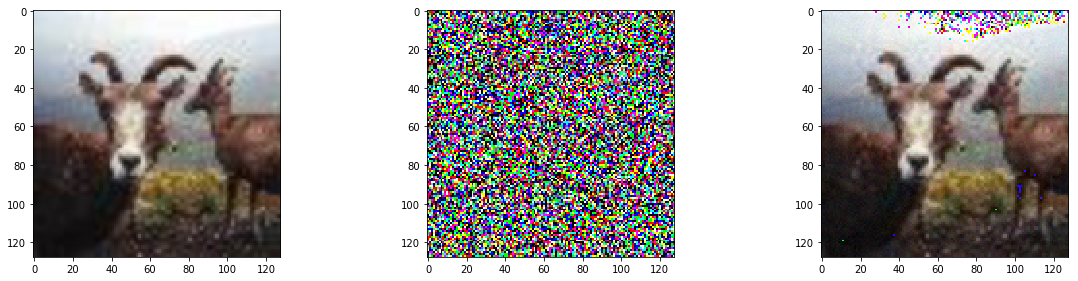

In [72]:
from IPython.display import display
I = np.asarray(datasets['val'][15][0])
e = np.array(np.random.normal(0, 5, (128, 128, 3)), dtype=np.uint8)
Ie = I + e
Ie = PIL.Image.fromarray(Ie)
I = PIL.Image.fromarray(I)
e = PIL.Image.fromarray(e)
#display(I, e, Ie)

import matplotlib.pyplot as plt

images = [I, e, Ie]
plt.figure(figsize=(20,10))
columns = 3
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

### Stability Training
Adversaries can optimize images by adding noise that fools the network to misclassify the inputs. In real world, random noise is more likely to occur (e.g. image compression, resizing, camera debris). This notebook explores random noise based on [Improving the Robustness of Deep Neural Networks via Stability Training](https://arxiv.org/pdf/1604.04326.pdf).

In [6]:
from torchvision.models import resnet18

In [7]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.model = resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        return self.model.forward(x)

In [8]:
def add_noise(inputs, sigma=1e-1, device="cpu"):
    noise = torch.distributions.normal.Normal(0, sigma).sample(inputs.shape)
    noise = noise.to(device)
    return inputs + noise

In [9]:
# This loss uses KL-divergence as the distance function
# To measure the correspondence between the likelihood on the natural and perturbed inputs.
import torch.nn.functional as F

def loss_stability(out_orig, out_noise):
    return -torch.sum(torch.sum(F.softmax(out_orig) * F.log_softmax(out_noise), dim=1)) / out_orig.size(0)

In [10]:
import time
import copy

def train_model_random_noise(model, dataloaders, criterion, optimizer, model_file, alpha=1e-2, sigma=1e-1, num_epochs=5):
    """
    Modified version of https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
    """
    since = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects_orig = 0
            running_corrects_stab = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # add noise
                inputs_noise = add_noise(inputs, sigma, device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs_orig = model(inputs)
                    outputs_noise = model(inputs_noise)
                    
                    loss_orig = criterion(outputs_orig, labels)
                    loss_stab = loss_stability(outputs_orig, outputs_noise)
                    loss_total = loss_orig + alpha * loss_stab
                    
                    _, preds_orig = torch.max(outputs_orig, 1)
                    _, preds_stab = torch.max(outputs_noise, 1)

                    if phase == 'train':
                        loss_total.backward()
                        optimizer.step()

                running_loss += loss_total.item() * inputs.size(0)
                running_corrects_orig += torch.sum(preds_orig == labels.data)
                running_corrects_stab += torch.sum(preds_stab == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects_orig.double() / len(dataloaders[phase].dataset)
            epoch_acc_stab = running_corrects_stab.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}, Noise Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_acc_stab))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load and save best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), model_file)
    
    stats = (train_acc_history, train_loss_history, val_acc_history, val_loss_history)
    return model, stats

In [15]:
# Model already trained
# model = Net(len(CLASS_NAMES))
params_to_update = [param for param in model.parameters() if param.requires_grad]
optim = torch.optim.Adam(params_to_update)
criterion = nn.CrossEntropyLoss()

In [17]:
model = Net(len(CLASS_NAMES))
model.load_state_dict(torch.load('models/random_noise.pt'))

<All keys matched successfully>

In [18]:
model, stats = train_model_random_noise(model, dataloaders, criterion, optim, 'models/random_noise.pt', alpha=1e-2, sigma=5e-2, num_epochs=5)

Epoch 0/4
----------


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


train Loss: 0.8340 Acc: 0.7897, Noise Acc: 0.7153
val Loss: 1.9853 Acc: 0.5433, Noise Acc: 0.5549

Epoch 1/4
----------
train Loss: 0.8342 Acc: 0.7901, Noise Acc: 0.7179
val Loss: 1.9716 Acc: 0.5472, Noise Acc: 0.5523

Epoch 2/4
----------
train Loss: 0.8343 Acc: 0.7895, Noise Acc: 0.7181
val Loss: 1.9839 Acc: 0.5459, Noise Acc: 0.5562

Epoch 3/4
----------
train Loss: 0.8340 Acc: 0.7895, Noise Acc: 0.7178
val Loss: 1.9676 Acc: 0.5497, Noise Acc: 0.5596

Epoch 4/4
----------
train Loss: 0.8340 Acc: 0.7892, Noise Acc: 0.7167
val Loss: 1.9782 Acc: 0.5442, Noise Acc: 0.5585

Training complete in 102m 25s
Best val Acc: 0.549700


In [19]:
def test_noise(model, val_data, sigma=1e-1):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    running_corrects = 0.0
    running_corrects_noise = 0.0
    model = model.to(device)
    for inputs, labels in val_data:
        model.eval()
        with torch.set_grad_enabled(False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            noise = torch.distributions.normal.Normal(0, sigma).sample(inputs.shape)
            noise = noise.to(device)
            inputs_noise = inputs + noise
            outputs = model(inputs)
            outputs_noise = model(inputs_noise)
            _, preds = torch.max(outputs, 1)
            _, preds_noise = torch.max(outputs_noise, 1)
            running_corrects += torch.sum(preds == labels.data)
            running_corrects_noise += torch.sum(preds_noise == labels.data)
    acc = running_corrects.double() / len(val_data.dataset)
    acc_noise = running_corrects_noise.double() / len(val_data.dataset)
    return acc, acc_noise

#### Compare model performance to the baseline

In [22]:
baseline_model = Net(len(CLASS_NAMES))
baseline_model.load_state_dict(torch.load('models/baseline.pt')) # change to baseline
acc_baseline, acc_noise_baseline = test_noise(baseline_model, dataloaders['val'])

In [23]:
print("Baseline validation accuracy on clean data: {:.4f}".format(acc_baseline.double()))
print("Baseline validation accuracy on noise data: {:.4f}".format(acc_noise_baseline.double()))

Baseline validation accuracy on clean data: 0.5719
Baseline validation accuracy on noise data: 0.3457


In [20]:
acc, acc_noise = test_noise(model, dataloaders['val'])

In [21]:
print("New model validation accuracy on clean data: {:.4f}".format(acc.double()))
print("New model validation accuracy on noise data: {:.4f}".format(acc_noise.double()))

New model validation accuracy on clean data: 0.5497
New model validation accuracy on noise data: 0.5340


Modified model has a slightly lower validation accuracy on the clean data but is much more robust to random noise. Practically, we should probably use a smaller alpha value to make the noise loss less important.

#### Train more layers including convolutional

In [32]:
class NetConv(nn.Module):
    def __init__(self, num_classes):
        super(NetConv, self).__init__()
        self.model = resnet18(pretrained=True)
        for param in list(self.model.parameters())[:-15]:
            param.requires_grad = False
        self.model.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        return self.model.forward(x)

In [33]:
model_conv = NetConv(len(CLASS_NAMES))
params_to_update = [param for param in model_conv.parameters() if param.requires_grad]
optim = torch.optim.Adam(params_to_update)
criterion = nn.CrossEntropyLoss()

In [34]:
model_conv, stats = train_model_random_noise(model_conv, dataloaders, criterion, optim, 'models/random_noise.pt', alpha=1e-1, sigma=1e-1, num_epochs=5)

Epoch 0/4
----------


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


train Loss: 2.3614 Acc: 0.4817, Noise Acc: 0.4659
val Loss: 2.2717 Acc: 0.5067, Noise Acc: 0.5180

Epoch 1/4
----------
train Loss: 1.4591 Acc: 0.6578, Noise Acc: 0.6127
val Loss: 2.2091 Acc: 0.5239, Noise Acc: 0.5489

Epoch 2/4
----------
train Loss: 0.8945 Acc: 0.7852, Noise Acc: 0.6954
val Loss: 2.3885 Acc: 0.5192, Noise Acc: 0.5368

Epoch 3/4
----------
train Loss: 0.4533 Acc: 0.8946, Noise Acc: 0.7667
val Loss: 2.6416 Acc: 0.5229, Noise Acc: 0.5308

Epoch 4/4
----------
train Loss: 0.2214 Acc: 0.9560, Noise Acc: 0.8177
val Loss: 2.9459 Acc: 0.5222, Noise Acc: 0.5293

Training complete in 131m 45s
Best val Acc: 0.523900


In [35]:
acc_conv, acc_noise_conv = test_noise(model_conv, dataloaders['val'])

In [37]:
print("New model validation accuracy on clean data: {:.4f}".format(acc_conv.double()))
print("New model validation accuracy on noise data: {:.4f}".format(acc_noise_conv.double()))

New model validation accuracy on clean data: 0.5239
New model validation accuracy on noise data: 0.5473
